In [139]:
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle as pkl
from xgboost import XGBClassifier
import json
from svmclassifier import SVMClassifier
from nnclassifier import NNClassifier
import matplotlib.pyplot as plt


## Load the one-hot encoded data
Use one-hot token method, since this performed better than category using the taxonomy  
`onehot_feature.json` is created using `onehot.py`

In [178]:
with open("../data/onehot_feature.json", 'r') as f:
    users = json.load(f)

### Remove "on target" class

In [179]:
data = [user for user in users if user["label"] != 2]

### Split the data into model input and output

In [180]:
le = LabelEncoder()

X_one_hot = [np.array(user["feature"]) for user in data]

labels = [user["label"] for user in data]
y_one_hot = le.fit_transform(labels)

## SVM with one-hot encoding input

In [185]:
scoring = {'accuracy':'accuracy',
           'precision_macro':make_scorer(precision_score,average='macro'),
           'recall_macro':make_scorer(recall_score,average='macro'),
           'precision_above':make_scorer(precision_score,average='binary',pos_label=1),
           'recall_above':make_scorer(recall_score,average='binary',pos_label=1)}

In [186]:
svc = SVC(kernel='linear')
svc_scores_one_hot = cross_validate(svc,X_one_hot,y_one_hot,scoring=scoring,cv=5)

In [183]:
def print_scores(scores):
    for metric in ['test_accuracy','test_precision_macro','test_recall_macro','test_precision_above','test_recall_above']:
        print('\n' + metric)
        print('Average ' + metric)
        print(round(np.mean(scores[metric]),4))
        print('Std of ' + metric)
        print(round(np.std(scores[metric]),6))

In [187]:
print_scores(svc_scores_one_hot)


test_accuracy
Average test_accuracy
0.6608
Std of test_accuracy
0.010967

test_precision_macro
Average test_precision_macro
0.5581
Std of test_precision_macro
0.011989

test_recall_macro
Average test_recall_macro
0.5685
Std of test_recall_macro
0.014025

test_precision_above
Average test_precision_above
0.3097
Std of test_precision_above
0.01712

test_recall_above
Average test_recall_above
0.399
Std of test_recall_above
0.025401


## MLP with one-hot encoding input

In [188]:
mlp_one_hot = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                             beta_2=0.999, early_stopping=False, epsilon=1e-08,
                             hidden_layer_sizes=(600), learning_rate='constant',
                             learning_rate_init=0.001, max_iter=200, momentum=0.9,
                             nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                             solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
                             warm_start=False)

In [189]:
mlp_scores_one_hot = cross_validate(mlp_one_hot,X_one_hot,y_one_hot,scoring=scoring,cv=5)

In [190]:
print_scores(mlp_scores_one_hot)


test_accuracy
Average test_accuracy
0.744
Std of test_accuracy
0.018301

test_precision_macro
Average test_precision_macro
0.6175
Std of test_precision_macro
0.030765

test_recall_macro
Average test_recall_macro
0.5958
Std of test_recall_macro
0.022283

test_precision_above
Average test_precision_above
0.4216
Std of test_precision_above
0.053364

test_recall_above
Average test_recall_above
0.3239
Std of test_recall_above
0.038977


## Prepare vectorized data for classification

### Load the model input
This input is constructed using `construct_classifier_input_data.ipynb`

In [197]:
data_w2v = pd.read_csv('../data/food_vectors_w2v.csv',header=None)
data_fasttext = pd.read_csv('../data/food_vectors_fasttext.csv',header=None)
data_w2v = data_w2v.rename(columns={0:'user',1:'date',102:'goal',103:'actual',104:'label'})


data_fasttext = data_fasttext.rename(columns={0:'user',1:'date',102:'goal',103:'actual',104:'label'})
data_fasttext = data_fasttext.rename(columns=lambda x: str(int(x) - 1) if x in data_fasttext.columns[2:102] else x)

In [198]:
data_fasttext.head()

,user,date,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,100,goal,actual,label
0,1,2014-09-14,-5.958106,-11.863085,14.124744,17.715162,7.297624,-16.876074,6.421110,-10.583551,...,1.713615,11.185937,5.823830,-15.392231,-9.979661,-11.421283,-2.338475,3173,2924,on_target
1,1,2014-09-15,-0.037711,0.105858,3.478882,0.565845,-2.449674,-0.779285,0.082059,-4.559442,...,-5.333766,3.976366,-1.588454,-2.370199,-0.725016,-0.723749,-1.332324,1572,2430,above
2,1,2014-09-16,0.279810,-3.100166,1.889815,4.690158,1.892064,-3.094592,3.842139,-1.731543,...,-3.889596,3.090257,1.940065,2.139145,2.167100,-0.516185,-4.824111,1832,1862,above
3,1,2014-09-17,2.376114,-6.151992,0.099034,4.389563,2.870405,-2.525932,5.718841,-1.314787,...,-5.449570,4.555738,3.303708,-1.385859,0.581540,0.252295,-4.752221,1685,2251,above
4,1,2014-09-18,2.278960,-7.586246,4.981245,7.169042,5.490237,-7.623795,1.791896,-4.606276,...,-1.456970,6.809816,0.922566,1.038426,-0.769862,-4.561421,-2.896708,1597,2001,above


In [199]:
data = data_fasttext

### Preprocessing and aggregation by user

Following the original paper, we discard days where less than 100 calories were logged

In [200]:
data = data[data['actual'] > 100]

### Remove "on target" class
Following the original paper, we discard the 'on_target' label, simplifying the problem to binary classification

In [201]:
data = data[data['label'] != 'on_target']

In [202]:
# data.head()

### Aggregate the data by user
We group the data by user, aggregate the vectors using the mean, and aggregate the users by taking the modal class.  
I.e. if most days that are recorded for a given user have been labeled "below", we label this user as "below"

In [203]:
groups = data.groupby('user')

Display the number of users with more than 30 days logged

In [204]:
len(groups['user'].count()[lambda x: x >= 30].index)

4781

Construct a new dataframe of the aggregate data

In [205]:
grouped_y = groups['label'].agg(lambda x:x.value_counts().index[0])
grouped_x = groups.mean()
grouped = grouped_x.copy()
grouped['label'] = grouped_y
grouped_above_30 = grouped.loc[groups['user'].count()[lambda x: x >= 30].index,:]

### Check the number of users in each class

In [206]:
above_num = sum(grouped_above_30['label'] == 'above')
below_num = sum(grouped_above_30['label'] == 'below')

print("Above: " + str(above_num))
print("Below: " + str(below_num))

Above: 1330
Below: 3451


### Balance the classes
We should try classification with the classes balanced, as the original paper did

In [207]:
grouped_above_30_balanced = grouped_above_30.copy()
below_indices = grouped_above_30_balanced[grouped_above_30_balanced['label'] == 'below'].index
n_remove = below_num - above_num
drop_indices = np.random.choice(below_indices, n_remove, replace=False)
grouped_above_30_balanced = grouped_above_30_balanced.drop(drop_indices)

In [208]:
above_num_balanced = sum(grouped_above_30_balanced['label'] == 'above')
below_num_balanced = sum(grouped_above_30_balanced['label'] == 'below')

print("Above: " + str(above_num_balanced))
print("Below: " + str(below_num_balanced))

Above: 1330
Below: 1330


### Split the data into model input and output

In [214]:
# grouped.head()

In [210]:
y_bal = grouped_above_30_balanced.loc[:,'label']
X_bal = grouped_above_30_balanced.iloc[:,0:100]
y_unbal = grouped_above_30.loc[:,'label']
X_unbal = grouped_above_30.iloc[:,0:100]

In [215]:
# X_bal.head()

In [216]:
# y.head()

## SVM using vector input

In [217]:
scoring = {'accuracy':'accuracy',
           'precision_macro':make_scorer(precision_score,average='macro'),
           'recall_macro':make_scorer(recall_score,average='macro'),
           'precision_above':make_scorer(precision_score,average='binary',pos_label='above'),
           'recall_above':make_scorer(recall_score,average='binary',pos_label='above')}

In [218]:
svc = SVC(kernel='linear')
svc_scores_vector_bal = cross_validate(svc,X_bal,y_bal,scoring=scoring,cv=5)

KeyboardInterrupt: 

In [162]:
svc_scores_vector_unbal = cross_validate(svc,X_unbal,y_unbal,scoring=scoring,cv=5)

In [168]:
print('Balanced:\n')
print_scores(svc_scores_vector_bal)
print('\nUnbalanced:\n')
print_scores(svc_scores_vector_unbal)

Balanced:


test_accuracy
Average test_accuracy
0.7248
Std of test_accuracy
0.016541

test_precision_macro
Average test_precision_macro
0.7257
Std of test_precision_macro
0.016587

test_recall_macro
Average test_recall_macro
0.7248
Std of test_recall_macro
0.016541

test_precision_above
Average test_precision_above
0.7393
Std of test_precision_above
0.018025

test_recall_above
Average test_recall_above
0.6947
Std of test_recall_above
0.020091

Unbalanced:


test_accuracy
Average test_accuracy
0.7793
Std of test_accuracy
0.006631

test_precision_macro
Average test_precision_macro
0.7379
Std of test_precision_macro
0.014651

test_recall_macro
Average test_recall_macro
0.6628
Std of test_recall_macro
0.005068

test_precision_above
Average test_precision_above
0.6756
Std of test_precision_above
0.028205

test_recall_above
Average test_recall_above
0.4
Std of test_recall_above
0.008768


## MLP using vector input

In [176]:
mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                             beta_2=0.999, early_stopping=False, epsilon=1e-08,
                             hidden_layer_sizes=(10), learning_rate='constant',
                             learning_rate_init=0.001, max_iter=200, momentum=0.9,
                             nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                             solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
                             warm_start=False)
mlp_scores_vector_bal = cross_validate(mlp,X_bal,y_bal,scoring=scoring,cv=5,verbose=1)
mlp_scores_vector_unbal = cross_validate(mlp,X_unbal,y_unbal,scoring=scoring,cv=5,verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [177]:
print('Balanced:\n')
print_scores(mlp_scores_vector_bal)
print('\nUnbalanced:\n')
print_scores(mlp_scores_vector_unbal)

Balanced:


test_accuracy
Average test_accuracy
0.7173
Std of test_accuracy
0.005652

test_precision_macro
Average test_precision_macro
0.718
Std of test_precision_macro
0.00579

test_recall_macro
Average test_recall_macro
0.7173
Std of test_recall_macro
0.005652

test_precision_above
Average test_precision_above
0.7285
Std of test_precision_above
0.009143

test_recall_above
Average test_recall_above
0.6932
Std of test_recall_above
0.018356

Unbalanced:


test_accuracy
Average test_accuracy
0.7768
Std of test_accuracy
0.00894

test_precision_macro
Average test_precision_macro
0.7272
Std of test_precision_macro
0.015822

test_recall_macro
Average test_recall_macro
0.6726
Std of test_recall_macro
0.011557

test_precision_above
Average test_precision_above
0.647
Std of test_precision_above
0.028669

test_recall_above
Average test_recall_above
0.4376
Std of test_recall_above
0.024317


# Save models and performance results to file

In [62]:
pkl.dump(svc,open('../predictive_models/svm_model.pkl','wb'))
pkl.dump(scores,open('../predictive_models/svm_5_fold_scores.pkl','wb'))

# Feature importances using vectors

Fit the whole dataset to examine the most important features

In [221]:
svc_feat_imp = SVC(kernel='linear')
svc_feat_imp.fit(X_bal,y_bal)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

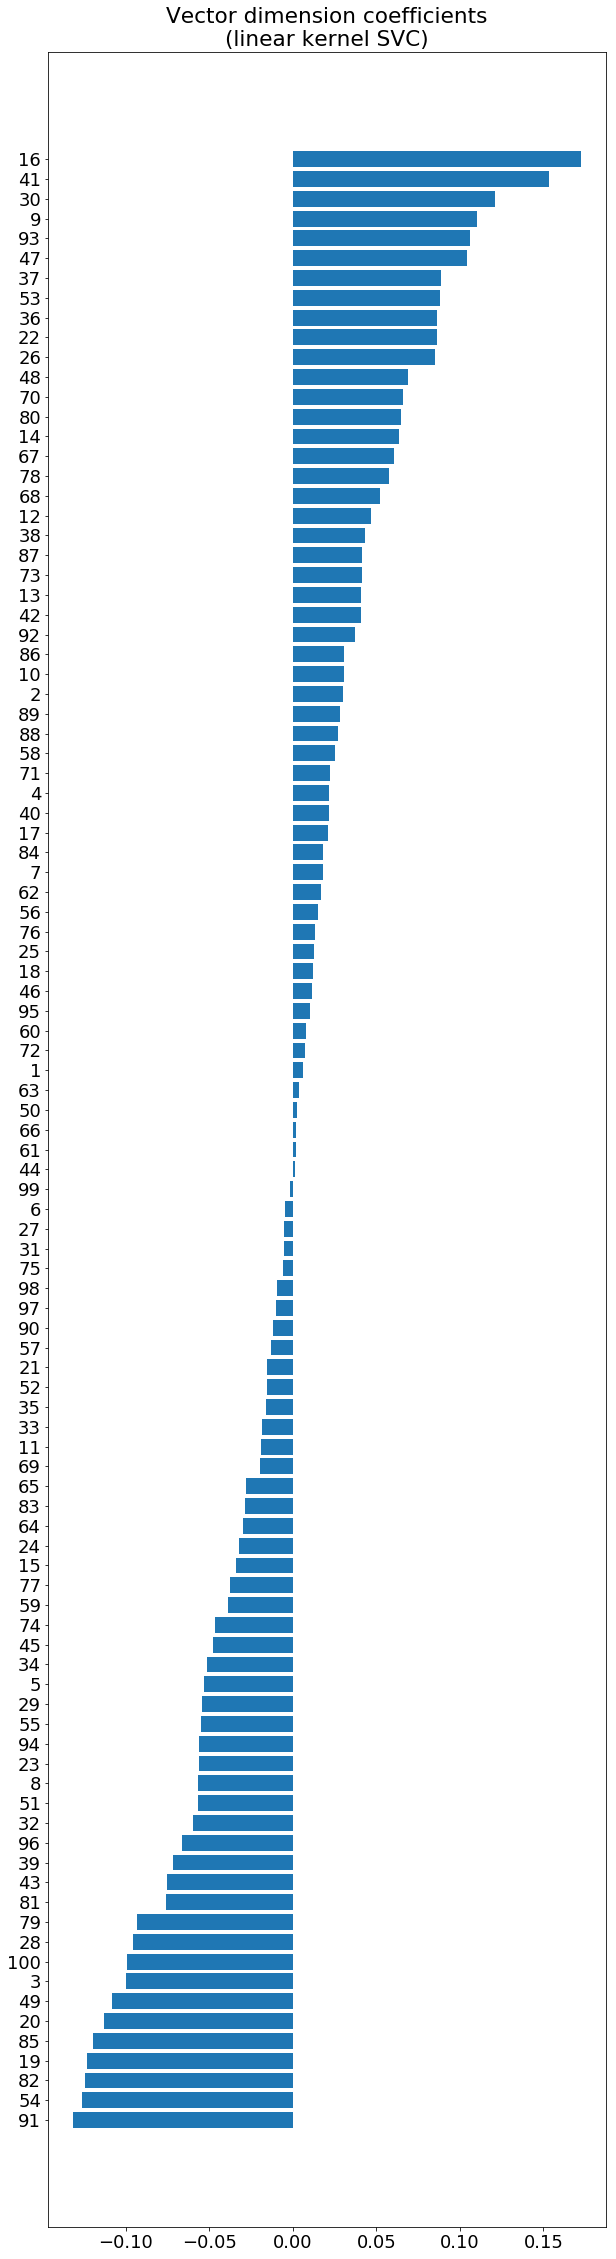

In [228]:
from pylab import rcParams
rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 10, 40

def f_importances(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title('Vector dimension coefficients\n(linear kernel SVC)')
    plt.show()
    return [imp,names]
    
f_imp = f_importances(svc_feat_imp.coef_, X_bal.columns[0:100])

In [235]:
import pickle

In [239]:
with open('./negative.pkl','wb') as f:
    pickle.dump(f_imp[1][0:47],f)

In [240]:
with open('./positive.pkl','wb') as f:
    pickle.dump(f_imp[1][47:],f)